## 股價預測
利用DataReader從yahoo finance抓取從1999年開始股價資料(共20年)，
再利用4種不同方式(Linear regression/SVM/Quadratic Regression 2/Quadratic Regression 3)進行股價預測，並以confidence level最高者的預測結果以圖形呈現股價未來走勢。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

### pandas_datareader
用pandas_datareader.data as web要先在cmd命令列中執行pip install pandas_datareader

In [18]:
ham = input("請輸入想搜尋的股票在Yahoo Finance上的Ticker: ")

請輸入想搜尋的股票在Yahoo Finance上的Ticker: AMZN


In [19]:
from time import strftime
from datetime import datetime, timedelta
start = datetime(1999, 1, 1)
datetime.now().strftime('%Y-%m-%d')
end = datetime.now()

df = web.DataReader(ham, 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-23,1793.000000,1784.510010,1788.260010,1793.000000,2136400.0,1793.000000
2019-12-24,1795.569946,1787.579956,1793.810059,1789.209961,881300.0,1789.209961
2019-12-26,1870.459961,1799.500000,1801.010010,1868.770020,6005400.0,1868.770020
2019-12-27,1901.400024,1866.010010,1882.920044,1869.800049,6186600.0,1869.800049
2019-12-30,1884.000000,1840.619995,1874.000000,1846.890015,3674700.0,1846.890015


### Rolling Mean (Moving Average) — to determine trend

In [20]:
close_px = df['Adj Close']
close_px = close_px.to_frame()
close_px = close_px.iloc[4000:, -1]
close_px = close_px.to_frame()
mavg_5 = close_px.rolling(window = 5).mean()
mavg_20 = close_px.rolling(window = 20).mean()
mavg_60 = close_px.rolling(window = 60).mean()

In [21]:
close_px

,Adj Close
Date,
2014-11-24,335.640015
2014-11-25,335.040009
2014-11-26,333.570007
2014-11-28,338.640015
2014-12-01,326.000000
2014-12-02,326.309998
2014-12-03,316.500000
2014-12-04,316.929993
2014-12-05,312.630005


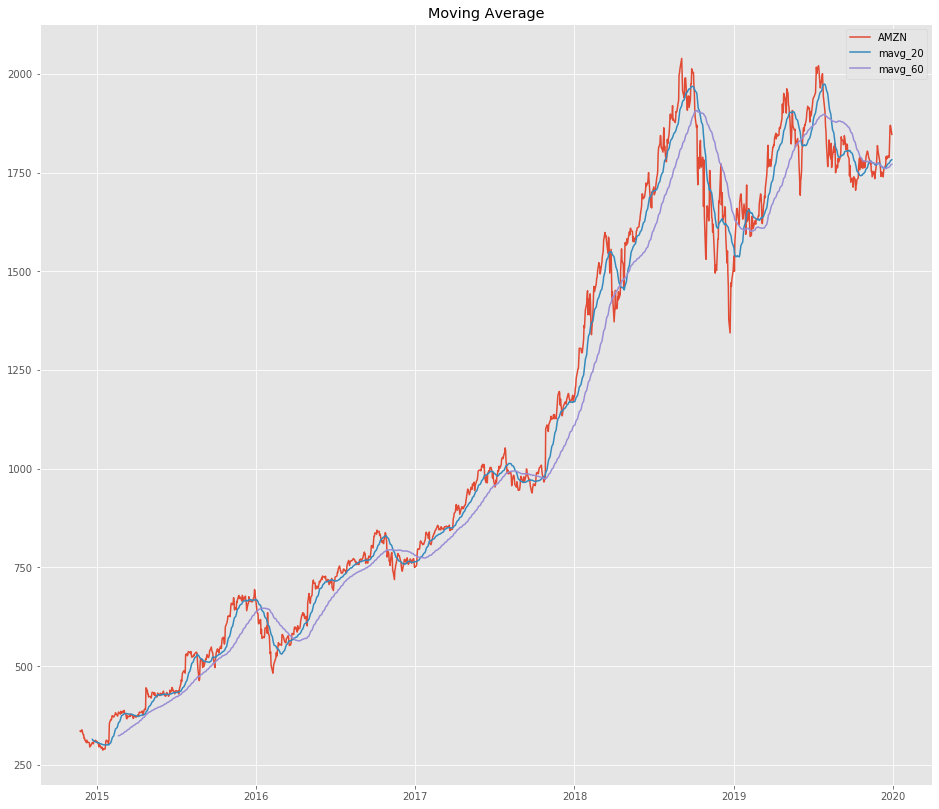

In [22]:
from matplotlib import style
import matplotlib as mpl
mpl.rc('figure', figsize=(16, 14))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

plt.title('Moving Average')
plt.plot(close_px, label=ham)
plt.plot(mavg_20, label='mavg_20')
plt.plot(mavg_60, label='mavg_60')
plt.legend()

### Return Deviation — to determine risk and return

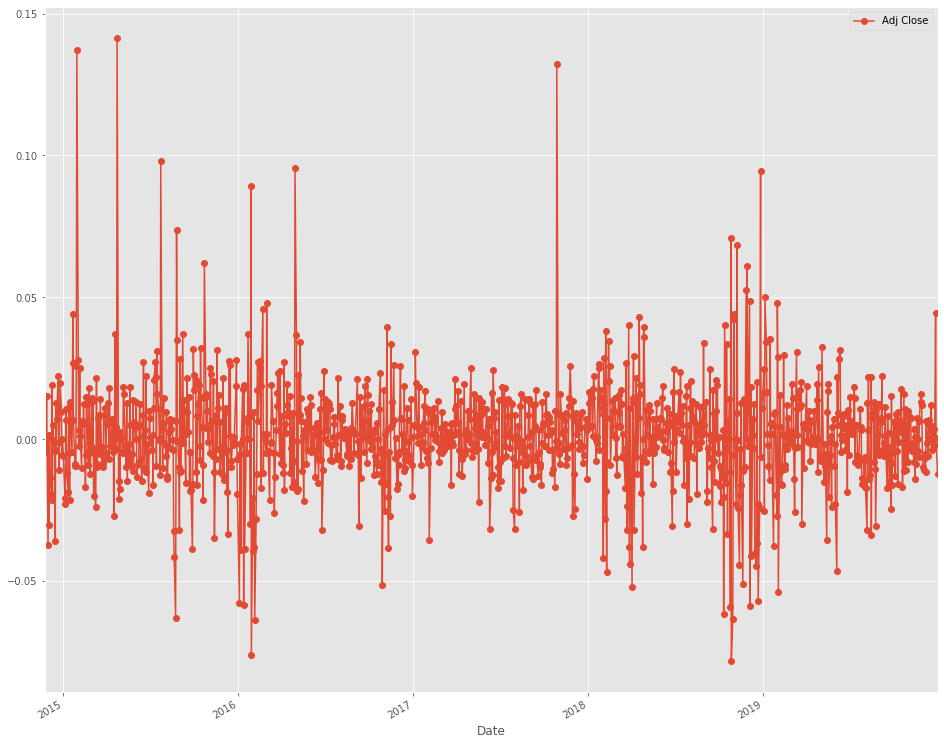

In [23]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return', marker = 'o')

### Stock Price Prediction
ref:　https://medium.com/@randerson112358/predict-stock-prices-using-python-machine-learning-53aa024da20a

### Model Generation

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [25]:
# Get the Adjusted Close Price 
df = df[['Adj Close']] 
# Take a look at the new data 
df.head()

,Adj Close
Date,
1998-12-31,53.541668
1999-01-04,59.156250
1999-01-05,62.250000
1999-01-06,69.000000
1999-01-07,79.437500


### Preparation
1. Create a variable called forecast_out, to store the number of days (30 days) into the future that I want to predict.
2. Need a column (the target or dependent variable) that will hold the predicted price values 30 days into the future. The future price that I want that’s 30 days into the future is just 30 rows down from the current Adj. Close price. So I will create a new column called ‘Prediction’ and populate it with data from the Adj. Close column but shifted 30 rows up to get the price of the next 30 days, and then print the last 5 rows of the new data set.

*Since shifted the data up 30 rows, the last 30 rows of data for the new column ‘Prediction’ will be empty or contain the value ‘NaN’ (Not A Number).

In [26]:
# A variable for predicting 'n' days out into the future
forecast_out = 30 #'n=30' days
#Create another column (the target ) shifted 'n' units up
df['Prediction'] = df[['Adj Close']].shift(-forecast_out)
#print the new data set
print(df.tail())

              Adj Close  Prediction
Date                               
2019-12-23  1793.000000         NaN
2019-12-24  1789.209961         NaN
2019-12-26  1868.770020         NaN
2019-12-27  1869.800049         NaN
2019-12-30  1846.890015         NaN


### Seperate data - x
Create the independent data set (X) that will be use to train the machine learning model(s). 
- STEP1: Create a variable called ‘X’ 
- STEP2: Convert the data into a numpy (np) array after dropping the ‘Prediction’ column, then store this new data into ‘X’.
- STEP3: Remove the last 30 rows of data from ‘X’, and store the new data back into ‘X’.

In [27]:
# Create the independent data set (X)
# and convert the dataframe to a numpy array
X = np.array(df.drop(['Prediction'], 1))

#Remove the last '30' rows
X = X[:-forecast_out]
print(X)

[[  53.54166794]
 [  59.15625   ]
 [  62.25      ]
 ...
 [1778.        ]
 [1753.10998535]
 [1754.59997559]]


### Seperate data - y
Create the independent data set as previous step called ‘y’. This is the target data, the one that holds the future price predictions.
- STEP1: Convert the data frame into a numpy array.
- STEP2: from the ‘Prediction’ column, store it into a new variable called ‘y’
- STEP3: Remove the last 30 rows of data from ‘y’. 

In [28]:
# Create the dependent data set (y)
# Convert the dataframe to a numpy array 
y = np.array(df['Prediction'])
# Get all of the y values except the last '30' rows
y = y[:-forecast_out]

#*Make sure their are no NaN in y.
np.isnan(y)

array([False, False, False, ..., False, False, False])

In [29]:
# Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Support Vector Machine (SVM)

In [30]:
# Create and train the Support Vector Machine (Regressor) 
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1) 
svr_rbf.fit(x_train, y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [31]:
# Testing Model: Score returns the coefficient of determination R^2 of the prediction. 
# The best possible score is 1.0
svm_confidence = svr_rbf.score(x_test, y_test)
print("svm confidence: ", svm_confidence)

svm confidence:  0.9803883482251887


### Linear Regression

In [32]:
# Create and train the Linear Regression  Model
lr = LinearRegression()
# Train the model
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
# Testing Model: Score returns the coefficient of determination R^2 of the prediction. 
# The best possible score is 1.0
lr_confidence = lr.score(x_test, y_test)
print("lr confidence: ", lr_confidence)

lr confidence:  0.9897758518355197


### Quadratic Regression

In [34]:
# Quadratic Regression 2
poly2 = make_pipeline(PolynomialFeatures(2), Ridge())
poly2.fit(x_train, y_train)
poly2_confidence = poly2.score(x_test, y_test)
print("Poly2 confidence: ", poly2_confidence)

# Quadratic Regression 3
poly3 = make_pipeline(PolynomialFeatures(3), Ridge())
poly3.fit(x_train, y_train)
poly3_confidence = poly3.score(x_test, y_test)
print("Poly3 confidence: ", poly3_confidence)

Poly2 confidence:  0.9904560548939731
Poly3 confidence:  0.9919741742341469


C:\Users\usernb\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.98183e-23): result may not be accurate.
  overwrite_a=True).T


In [35]:
highestConfidence = max(svm_confidence, lr_confidence, poly2_confidence, poly3_confidence)
if highestConfidence == svm_confidence:
    egg = 1
    egg_1 = "Use SVM to predict stock price - confidence =  " + str(highestConfidence)
    print(egg_1)
elif highestConfidence == lr_confidence:
    egg = 2
    egg_2 = "Use Linrear Regression Model to predict stock price - confidence =  " + str(highestConfidence)
    print(egg_2)
elif highestConfidence == poly2_confidence:
    egg = 3
    egg_3 = "Use Quadratic Regression 2 to predict stock price - confidence =  " + str(highestConfidence)
    print(egg_3)
elif highestConfidence == poly3_confidence:
    egg = 4
    egg_4 = "Use Quadratic Regression 3 to predict stock price - confidence =  " + str(highestConfidence)
    print(egg_4)

print(egg)

Use Quadratic Regression 3 to predict stock price - confidence =  0.9919741742341469
4


### Choose the model with highest confidence
- STEP1: Take the last 30 rows of data from the data frame of the Adj. Close price, and store it into a variable called x_forecast after transforming it into a numpy array.
- STEP2: Drop the ‘Prediction’ column of course.

In [36]:
# Set x_forecast equal to the last 30 rows of the original data set from Adj. Close column
x_forecast = np.array(df.drop(['Prediction'],1))[-forecast_out:]
print(x_forecast)

[[1739.48999023]
 [1752.5300293 ]
 [1752.79003906]
 [1745.5300293 ]
 [1734.70996094]
 [1745.7199707 ]
 [1773.83996582]
 [1796.93994141]
 [1818.51000977]
 [1800.80004883]
 [1781.59997559]
 [1769.95996094]
 [1760.68994141]
 [1740.47998047]
 [1751.59997559]
 [1749.51000977]
 [1739.20996094]
 [1748.7199707 ]
 [1760.32995605]
 [1760.93994141]
 [1769.20996094]
 [1790.66003418]
 [1784.0300293 ]
 [1792.2800293 ]
 [1786.5       ]
 [1793.        ]
 [1789.20996094]
 [1868.77001953]
 [1869.80004883]
 [1846.89001465]]


In [37]:
# Print linear regression model predictions for the next '30' days

if highestConfidence == svm_confidence:
    svm_prediction = svr_rbf.predict(x_forecast)
    print(svm_prediction)
elif highestConfidence == lr_confidence:
    lr_prediction = lr.predict(x_forecast)
    print(lr_prediction)
elif highestConfidence == poly2_confidence:
    poly2_prediction = poly2.predict(x_forecast)
    print(poly2_prediction)
elif highestConfidence == poly3_confidence:
    poly3_prediction = poly3.predict(x_forecast)
    print(poly3_prediction)

[1758.84469114 1766.49026844 1766.64076493 1762.40985969 1755.99430791
 1762.52130911 1778.56872636 1791.06799539 1802.16994888 1793.09551075
 1782.83716681 1776.40834769 1771.176688   1759.43184178 1765.95131618
 1764.73664041 1758.67841034 1764.2761884  1770.97153969 1771.3190708
 1775.98874596 1787.73185784 1784.15942569 1788.59691259 1785.49633455
 1788.98037531 1786.95492193 1825.8410845  1826.29333251 1815.91987248]


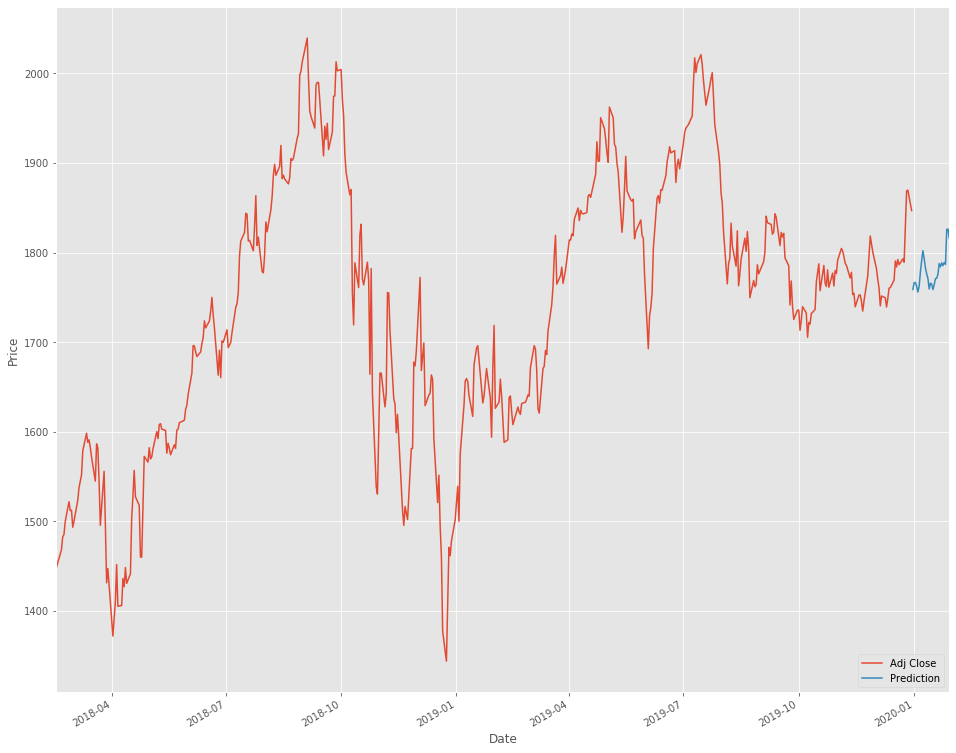

In [38]:
last_date = df.iloc[-1].name
last_unix = last_date
next_unix = last_unix + timedelta(days=1)

if egg == 1:
    for i in svm_prediction:
        next_date = next_unix
        next_unix += timedelta(days=1)
        df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
elif egg == 2:
    for i in lr_prediction:
        next_date = next_unix
        next_unix += timedelta(days=1)
        df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
elif egg == 3:
    for i in poly2_prediction:
        next_date = next_unix
        next_unix += timedelta(days=1)
        df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
elif egg == 4:
    for i in poly3_prediction:
        next_date = next_unix
        next_unix += timedelta(days=1)
        df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
        

df['Adj Close'].tail(500).plot()
df['Prediction'].tail(30).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
